In [1]:
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

# Random Query Data

In [2]:
query_tag = 'saved/2020-05-20T12:34:11.607267'
query_conf_name ='query'
algorithms = ['charge', 'charge_tweaked', 'classic', 'insert']

tag = 'saved/2020-05-20T09:10:07.525975'
conf_name ='init'
add_queries = ['charge', 'charge_tweaked']

In [3]:
def get_query_data(tag, conf_name, algorithms):
    # Paths to Benchmark Results
    result_dir = Path('./results').joinpath(tag, conf_name)
    
    data = {}
    for alg in algorithms:
        path = result_dir.joinpath(f'{alg}.csv')
        data[alg] = pd.read_csv(path,dtype={'start_node': str, 'target_node': str})

    return data
query_data = get_query_data(query_tag, query_conf_name, algorithms)

In [4]:
fmt = '{:<30}{:<20}{:<20}{:<5}'
print(f'--- Query Time ---')
print('')
print(fmt.format('Alg', 'Mean', 'Std', '# Num'))
print('')
fields = defaultdict(lambda: ['query_time'])
fields['insert'] = [
    'time_insert_start',
    'time_insert_target',
    'time_contracted_graph',
    'time_state_graph'
]
for alg in algorithms:
    try:
        for field in fields[alg]:
            print(fmt.format(
                f'{alg} ({field})',
                query_data[alg][field].mean(),
                query_data[alg][field].std(),
                len(query_data[alg])
            ))
    except KeyError:
        pass

--- Query Time ---

Alg                           Mean                Std                 # Num

charge (query_time)           85.27761389769998   77.9193280164897    100  
charge_tweaked (query_time)   57.56927005689002   52.6557023045811    100  
classic (query_time)          0.08957232191001822 0.05536630870305622 100  
insert (time_insert_start)    8.03584373575004    3.0550851545003987  100  
insert (time_insert_target)   8.460060523670018   2.9435430245651575  100  
insert (time_contracted_graph)140.1607599659983   0.0                 100  
insert (time_state_graph)     0.18398453400004652 0.0                 100  


In [5]:
query_data['charge_tweaked']['dominance_checks'].mean()

1686806.05

## Gasstation Characteristics

In [6]:
def get_init_data(tag, conf_name, add_queries):
    # Paths to Benchmark Results
    result_dir = Path('./results').joinpath(tag, conf_name)
    return {
        'init': pd.read_csv(result_dir.joinpath('init.csv')),
        'insert': pd.read_csv(
            result_dir.joinpath('insert.csv'),
            dtype={'start_node': str, 'target_node': str}
        ),
        'queries': get_query_data(tag, conf_name, add_queries)
    }
        
data = get_init_data(tag, conf_name, add_queries)

In [7]:
init, insert, add_queries = data['init'], data['insert'], data['queries']

In [8]:
insert.head()

start_node target_node  charging_stations  time_insert_start  \
0   317895723  4022528574                  8           2.235411   
1  6375674156  6703133844                  8           2.443919   
2   274491567   269838573                  8           2.008449   
3  3304756500  6536945476                  8           1.303239   
4  1970213121   387403323                  8           1.982175   

   time_insert_target  time_contracted_graph  time_state_graph  run_id  
0            2.266439               5.617017          0.001548       0  
1            1.560393               5.617017          0.001548       0  
2            1.723604               5.617017          0.001548       0  
3            2.368224               5.617017          0.001548       0  
4            2.155442               5.617017          0.001548       0

In [9]:
init.head()

time_contracted_graph  time_state_graph  nodes_state_graph  \
0               5.617017          0.001548                 22   
1               3.285679          0.001412                  8   
2               3.401741          0.001518                 22   
3               2.903394          0.001292                  8   
4               4.938236          0.001388                  8   

   edges_state_graph  nodes_contracted_graph  edges_contracted_graph  \
0                105                       8                      28   
1                 56                       8                      28   
2                105                       8                      28   
3                 56                       8                      28   
4                 56                       8                      28   

    av_cs_dist  charging_stations  run_id  
0  2935.156846                  8       0  
1  2464.685397                  8       1  
2  2364.264133                  8       2  
3  2054.784877                  8       3  
4  2824.463466                  8       4

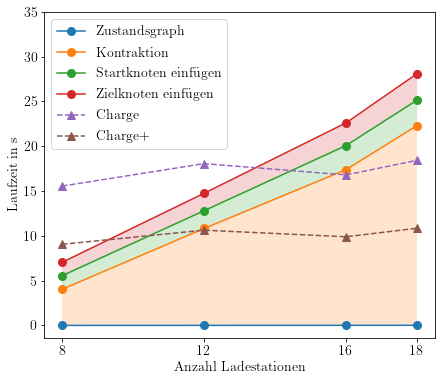

In [51]:
def plot_init_times(init, insert, add_queries=None):
    """:param df: Init Data"""

    def plot_cumsum_lines(x, ys, stds, labels=None):
        num_data = len(x)
        if labels is None:
            labels = num_data * ['']
        
        y_old = np.zeros(num_data)
        
        for y, std, label in zip(ys, stds, labels):
            y += y_old
            #plt.errorbar(x, y, yerr=std, fmt='o-', capsize=4, label=label)
            plt.plot(x, y, 'o-', label=label, markersize=8)
            plt.fill_between(
                x, 
                y_old, 
                y, 
                len(x) * [True], 
                alpha=0.2
            )
            y_old = y.copy()
        
    init_means = init.groupby('charging_stations').mean()
    init_std =  init.groupby('charging_stations').std()
    
    insert_means = insert.groupby('charging_stations').mean()
    insert_std = insert.groupby('charging_stations').std()
    
    
    x = init_means.index
    y = [
        init_means['time_state_graph'],
        init_means['time_contracted_graph'],
        insert_means['time_insert_start'],
        insert_means['time_insert_target']
    ]
    std = [
        init_std['time_state_graph'],
        init_std['time_contracted_graph'],
        insert_std['time_insert_start'],
        insert_std['time_insert_target']
    ]
    
    labels = [
        'Zustandsgraph',
        'Kontraktion',
        'Startknoten einfügen',
        'Zielknoten einfügen'
    ]
    
    fig = plt.figure(figsize=(7,6))
    plot_cumsum_lines(x, y, std, labels)
    plt.xticks(x)
    plt.xlabel('Anzahl Ladestationen')
    plt.ylabel('Laufzeit in s')
    #first_legend = plt.legend(loc='upper left')
    #ax = plt.gca().add_artist(first_legend)

    if add_queries is not None:
        names = {
            'charge': 'Charge',
            'charge_tweaked': 'Charge+'
        }
        handles = []
        for k, df in add_queries.items():
            
            means = df.groupby('charging_stations').mean()['query_time']
            std = df.groupby('charging_stations').std()['query_time']
            """
            plt.errorbar(
                means.index.values, 
                means, 
                yerr=std, 
                fmt='o-',
                capsize=4,
                label=names[k])
            
            """
            line, = plt.plot(
                means.index.values, 
                means, 
                '^--', 
                label=names[k],
                zorder=3,
                markersize=8
                )
            #"""
            handles.append(line)
            
        plt.legend(loc='upper left')

    y_min, y_max = plt.ylim()
    plt.ylim(y_min, 35)
    plt.savefig('img/charging_stations.pdf', bbox='tight')

    
plot_init_times(init, insert, add_queries)